# Red Neuronal Perceptrón Multicapa en PyTorch

Implementación de una red neuronal artificial de arquitectura perceptrón multicapa utilizando la interfaz de PyTorch.
La aplicación utilizada para probar la implementación del modelo es la del reconocimiento de dígitos escritos a mano, MNIST.

Autor: M. en C. Mario Xavier Canche Uc, Agosto 2020, mario.canche@cimat.mx

Basado en: https://www.cimat.mx/~mrivera/cursos/aprendizaje_profundo/nn_multicapa/nn_multicapa.html

## Cargamos las librerias

In [1]:
# Importamos las librerias de PyTorch
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms

import torch.nn.functional as F
import time

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score 
import seaborn as sns 

## Cargamos la base de datos MNIST

In [2]:
# Descargamos el dataset
root = '/Users/xaviercanche/Dropbox/Cimat2020/clases/Aprendizaje_Maquina_II/datasets'

#torch.manual_seed(123) #fijamos la semilla
trans = transforms.Compose([transforms.ToTensor()]) #Transformador para el dataset

train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans)

In [3]:
# preprocesamos los datos
batch_size   = 128
train_loader = torch.utils.data.DataLoader( dataset = train_set, batch_size = batch_size, shuffle = True  )
test_loader  = torch.utils.data.DataLoader( dataset = test_set , batch_size = batch_size, shuffle = False )

print ('Trainning batch number: {}'.format(len(train_loader)))
print ('Testing batch number: {}'.format(len(test_loader)))

Trainning batch number: 469
Testing batch number: 79


## Definimos la Arquitectura de la Red

In [4]:
# Arquitectura de la red
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 512) # capa oculta 
        self.fc2 = nn.Linear(512, 10) # capa de salida 
        
        self.loss_criterion = nn.CrossEntropyLoss() # Función de pérdida

    def forward(self, x, target):
        # transforma las imágenes de tamaño (n, 28, 28) a (n, 784)
        x = x.view(-1, 28*28) 
        
        # Capa oculta y su funcion de activacion
        x = F.relu(self.fc1(x)) # Función de activación relu en la salida de la capa oculta
        
        # Capa de salida y su funcion de activacion
        x = F.softmax(self.fc2(x), dim=1) # Función de activación softmax en la salida de la capa de salida
        
        loss = self.loss_criterion(x, target) # Calculo de la función de pérdida 
        return x, loss


In [5]:
# Instanciamos el modelo y agregamos el optimizador
model = MLP()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, momentum=0.0, alpha=0.9, eps=1e-07)
###optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

## Entrenamos el Modelo

In [6]:
# Funcion para Entrenar la red
def evaluate(model, dataset_loader, optimizer, train=False):
    
    correct_cnt = 0 # contador de aciertos
    ave_loss = 0 # acumulador de la función de pérdida
    count = 0 # contador de muestras
    
    for batch_idx, (x, target) in enumerate(dataset_loader):
        # sumamos el tamaño de batch, esto es porque n_batches*tamaño_batch != n_muestras
        count += len(x)
        
        if train:
            optimizer.zero_grad() # iniciamos a 0 los valores de los gradiente
            
        # Convertimos el tensor a variable del modulo autograd
        x = Variable(x)
        target = Variable(target)
        
        score, loss = model(x, target) # predecimos con el metodo forward
        _, pred_label = torch.max(score.data, 1) # pasamos de one hot a número
        correct_cnt += (pred_label == target.data).sum() # calculamos el número de etiquetas correctas
        ave_loss += loss.item() # sumamos el resultado de la función de pérdida para mostrar después
        
        if train:
            loss.backward() # calcula los gradientes y los propaga 
            optimizer.step() # adaptamos los pesos con los gradientes propagados
    
    accuracy = int(correct_cnt)/count # calculamos la precisión total
    ave_loss /= count # calculamos la pérdida media
    
    print ('==>>> loss: {:.6f}, accuracy: {:.4f}'.format(ave_loss, accuracy)) # mostramos resultados

In [7]:
# Entrenamos la Red
tic=time.time()
for epoch in range(10):
    print("Epoch: {}".format(epoch))
    print("Train")
    evaluate(model, train_loader, optimizer, train=True)
    print('Tiempo: {} secs'.format(time.time()-tic))

Epoch: 0
Train
==>>> loss: 0.012394, accuracy: 0.8982
Tiempo: 14.091159105300903 secs
Epoch: 1
Train
==>>> loss: 0.011880, accuracy: 0.9465
Tiempo: 28.448319911956787 secs
Epoch: 2
Train
==>>> loss: 0.011756, accuracy: 0.9608
Tiempo: 43.65545988082886 secs
Epoch: 3
Train
==>>> loss: 0.011686, accuracy: 0.9692
Tiempo: 58.38509273529053 secs
Epoch: 4
Train
==>>> loss: 0.011639, accuracy: 0.9747
Tiempo: 74.01159596443176 secs
Epoch: 5
Train
==>>> loss: 0.011609, accuracy: 0.9784
Tiempo: 88.90223002433777 secs
Epoch: 6
Train
==>>> loss: 0.011583, accuracy: 0.9811
Tiempo: 103.38857769966125 secs
Epoch: 7
Train
==>>> loss: 0.011563, accuracy: 0.9833
Tiempo: 118.71666884422302 secs
Epoch: 8
Train
==>>> loss: 0.011545, accuracy: 0.9856
Tiempo: 133.50229692459106 secs
Epoch: 9
Train
==>>> loss: 0.011531, accuracy: 0.9872
Tiempo: 149.6485607624054 secs


In [8]:
# Evaluamos el conjunto de test
print("Test")
evaluate(model, test_loader, optimizer, train=False)

Test
==>>> loss: 0.011723, accuracy: 0.9783


## Graficamos la matriz de confusión

In [9]:
# Extraemos las etiquetas predichas
test_true_labels = []
test_predicted_labels = []

for batch_idx, (x, target) in enumerate(test_loader):
            
    # Convertimos el tensor a variable del modulo autograd
    x = Variable(x)
    target = Variable(target)
        
    score, loss = model(x, target) # predecimos con el metodo forward
    _, pred_label = torch.max(score.data, 1) # pasamos de one hot a número
    
    test_true_labels += target.numpy().tolist()
    test_predicted_labels += pred_label.numpy().tolist()

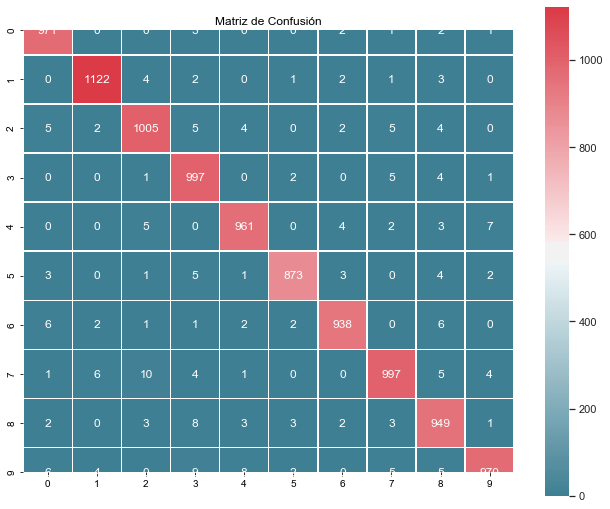

In [10]:
# Creamos la matriz de confusión
C = confusion_matrix(test_true_labels, test_predicted_labels)

f, ax = plt.subplots(figsize=(11, 9))
sns.set()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(C, cmap=cmap, square=True,
                 annot=True, fmt='d', linewidths=.5)
ax.set_title('Matriz de Confusión')
plt.show()